In [ ]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import random
import numpy as np
from transformers import (
    BertTokenizer,
    BertForMaskedLM,
    BertForSequenceClassification,
    BertModel,
    Trainer,
    TrainingArguments
)
from datasets import load_dataset, Dataset as HFDataset
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt


random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


ds = load_dataset("prasadsawant7/sentiment_analysis_preprocessed_dataset")

unlabeled_dataset = ds["train"].remove_columns(["labels"])
print("Number of samples for GAN (train split):", len(unlabeled_dataset))


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):

    texts = [str(text) if text is not None else "" for text in examples["text"]]
    return tokenizer(texts, truncation=True, padding="max_length", max_length=128)

unlabeled_dataset = unlabeled_dataset.map(tokenize_function, batched=True)
unlabeled_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask'])


unlabeled_dataloader = DataLoader(unlabeled_dataset, batch_size=32, shuffle=True)


generator = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)

discriminator = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)


gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-5)
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-5)


num_epochs_gan = 5
mask_prob = 0.15
for epoch in range(num_epochs_gan):
    generator.train()
    discriminator.train()
    total_gen_loss = 0
    total_disc_loss = 0
    for batch in tqdm(unlabeled_dataloader, desc=f"GAN Epoch {epoch+1}/{num_epochs_gan}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)


        rand = torch.rand(input_ids.shape).to(device)
        mask_positions = (rand < mask_prob) & (input_ids != tokenizer.cls_token_id) & (input_ids != tokenizer.sep_token_id)


        masked_input_ids = input_ids.clone()
        masked_input_ids[mask_positions] = tokenizer.mask_token_id


        gen_outputs = generator(masked_input_ids, attention_mask=attention_mask)
        gen_logits = gen_outputs.logits

        gen_tokens = input_ids.clone()
        if mask_positions.sum() > 0:
            gen_tokens[mask_positions] = torch.argmax(gen_logits, dim=-1)[mask_positions]


        real_labels = torch.ones(input_ids.size(0), dtype=torch.long).to(device)
        fake_labels = torch.zeros(input_ids.size(0), dtype=torch.long).to(device)


        disc_real_outputs = discriminator(input_ids=input_ids, attention_mask=attention_mask)
        loss_real = torch.nn.functional.cross_entropy(disc_real_outputs.logits, real_labels)

        disc_fake_outputs = discriminator(input_ids=gen_tokens, attention_mask=attention_mask)
        loss_fake = torch.nn.functional.cross_entropy(disc_fake_outputs.logits, fake_labels)
        disc_loss = (loss_real + loss_fake) / 2

        disc_optimizer.zero_grad()
        disc_loss.backward(retain_graph=True)
        disc_optimizer.step()
        total_disc_loss += disc_loss.item()


        disc_fake_outputs_for_gen = discriminator(input_ids=gen_tokens, attention_mask=attention_mask)
        gen_adv_loss = torch.nn.functional.cross_entropy(disc_fake_outputs_for_gen.logits, real_labels)

        gen_optimizer.zero_grad()
        gen_adv_loss.backward()
        gen_optimizer.step()
        total_gen_loss += gen_adv_loss.item()

    avg_gen_loss = total_gen_loss / len(unlabeled_dataloader)
    avg_disc_loss = total_disc_loss / len(unlabeled_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs_gan} - Generator Loss: {avg_gen_loss:.4f}, Discriminator Loss: {avg_disc_loss:.4f}")


generator.save_pretrained("/content/fine_tuned_bert_gan")




Some weights of BertModel were not initialized from the model checkpoint at /content/fine_tuned_bert_gan and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of samples for classification (test split): 20000
Train size: 16000 Val size: 4000

Starting classification training...


Epoch 1/3: 100%|██████████| 1000/1000 [01:40<00:00,  9.94it/s]


Epoch 1/3, Train Loss: 0.8180, Val Loss: 0.6575


Epoch 2/3: 100%|██████████| 1000/1000 [01:40<00:00,  9.97it/s]


Epoch 2/3, Train Loss: 0.5117, Val Loss: 0.6140


Epoch 3/3: 100%|██████████| 1000/1000 [01:40<00:00,  9.96it/s]


Epoch 3/3, Train Loss: 0.2789, Val Loss: 0.6820
Losses saved to losses_debug.txt


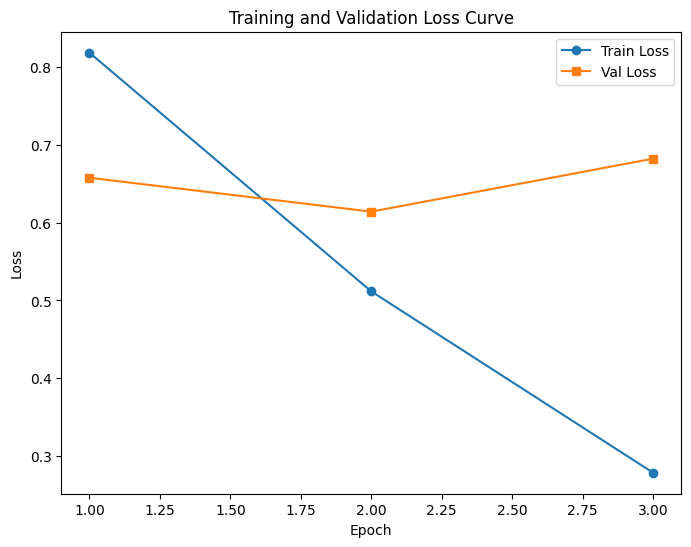


Final Test Accuracy (on val split): 0.77775
              precision    recall  f1-score   support

    Negative       0.78      0.82      0.80      1405
     Neutral       0.77      0.73      0.75      1234
    Positive       0.78      0.77      0.78      1361

    accuracy                           0.78      4000
   macro avg       0.78      0.78      0.78      4000
weighted avg       0.78      0.78      0.78      4000



In [ ]:

cls_dataset = ds["test"]
print("Number of samples for classification (test split):", len(cls_dataset))
labeled_texts = cls_dataset["text"]
labeled_labels = cls_dataset["labels"]


class SentimentDatasetIntegers(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        if text is None:
            text = ""
        if not isinstance(text, str):
            text = str(text)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].squeeze(0)
        attention_mask = encoding["attention_mask"].squeeze(0)
        return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": label}

full_dataset = SentimentDatasetIntegers(labeled_texts, labeled_labels, tokenizer, max_length=128)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
print("Train size:", len(train_dataset), "Val size:", len(val_dataset))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


class DebugCNNBiLSTMHighwayAttentionClassifier(nn.Module):
    def __init__(self, num_labels=3, bert_model_name="/content/fine_tuned_bert_gan",
                 cnn_out_channels=128, lstm_hidden=256, lstm_layers=1, dropout=0.5):
        super(DebugCNNBiLSTMHighwayAttentionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        bert_hidden_size = self.bert.config.hidden_size

        self.conv3 = nn.Conv1d(in_channels=bert_hidden_size, out_channels=cnn_out_channels,
                               kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=bert_hidden_size, out_channels=cnn_out_channels,
                               kernel_size=4, padding=2)
        self.conv5 = nn.Conv1d(in_channels=bert_hidden_size, out_channels=cnn_out_channels,
                               kernel_size=5, padding=2)
        self.layernorm = nn.LayerNorm(cnn_out_channels * 3)
        self.linear_proj = nn.Linear(cnn_out_channels * 3, lstm_hidden)

        self.lstm = nn.LSTM(
            input_size=lstm_hidden,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)

        self.highway_linear = nn.Linear(2 * lstm_hidden, 2 * lstm_hidden)
        self.highway_gate = nn.Linear(2 * lstm_hidden, 2 * lstm_hidden)

        self.attention_fc = nn.Linear(2 * lstm_hidden, 1)

        self.classifier = nn.Linear(2 * lstm_hidden, num_labels)

    def highway(self, x):
        H = F.relu(self.highway_linear(x))
        T = torch.sigmoid(self.highway_gate(x))
        return H * T + x * (1 - T)

    def attention_pooling(self, x):
        scores = self.attention_fc(x)
        weights = F.softmax(scores, dim=1)
        pooled = torch.sum(weights * x, dim=1)
        return pooled

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        x = sequence_output.transpose(1, 2)
        c3 = F.relu(self.conv3(x))
        c4 = F.relu(self.conv4(x))
        c5 = F.relu(self.conv5(x))
        seq_len = x.size(2)
        if c4.size(2) > seq_len:
            c4 = c4[:, :, :seq_len]
        conv_cat = torch.cat([c3, c4, c5], dim=1)
        conv_cat = conv_cat.transpose(1, 2)
        conv_cat = self.layernorm(conv_cat)
        proj_features = torch.sigmoid(self.linear_proj(conv_cat))
        lstm_out, _ = self.lstm(proj_features)
        lstm_out = self.dropout(lstm_out)
        highway_out = self.highway(lstm_out)
        pooled = self.attention_pooling(highway_out)
        logits = self.classifier(pooled)
        return logits


model_cls = DebugCNNBiLSTMHighwayAttentionClassifier(num_labels=3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_cls.parameters(), lr=2e-5)

num_epochs = 3
train_losses = []
val_losses = []

print("\nStarting classification training...")
for epoch in range(num_epochs):
    model_cls.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        logits = model_cls(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model_cls.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            logits = model_cls(input_ids, attention_mask)
            loss = criterion(logits, labels)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

with open("losses_debug.txt", "w") as f:
    f.write("Epoch,Train_Loss,Val_Loss\n")
    for i in range(num_epochs):
        f.write(f"{i+1},{train_losses[i]:.4f},{val_losses[i]:.4f}\n")
print("Losses saved to losses_debug.txt")

plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, marker='s', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.show()


model_cls.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        logits = model_cls(input_ids, attention_mask)
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print("\nFinal Test Accuracy (on val split):", acc)
print(classification_report(all_labels, all_preds, target_names=["Negative", "Neutral", "Positive"]))

In [ ]:
# Import required libraries
import os
from transformers import BertTokenizer, BertForMaskedLM, Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
from datasets import Dataset
import torch
import random

# Set the random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Load BERT tokenizer and model for masked language modeling
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased')

# Preprocess function for tokenization
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, padding=True, max_length=512)

# Load and prepare the unlabeled data for self-supervised training
def load_unlabeled_data():
    unsup_files = os.listdir('/content/aclImdb/train/unsup')
    texts = []
    for file in unsup_files:
        with open(f'/content/aclImdb/train/unsup/{file}', 'r', encoding='utf-8') as f:
            texts.append({'text': f.read()})
    return Dataset.from_list(texts)

unlabeled_dataset = load_unlabeled_data()
unlabeled_dataset = unlabeled_dataset.map(preprocess_function, batched=True)

# Data collator for masked language modeling (MLM)
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Training Arguments
training_args = TrainingArguments(
    output_dir='/content/results',
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
    learning_rate=2e-4,
    logging_dir='/content/logs',
    logging_steps=500,
    report_to="none"  # Disable wandb logging
)

# Trainer for self-supervised learning with masked language modeling
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=unlabeled_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Now we can load the labeled data and use the BERT sequence classification model for testing
from transformers import BertForSequenceClassification

# Load the BERT model for sequence classification
classification_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
classification_model.load_state_dict(model.state_dict(), strict=False)  # Load weights from MLM-trained model

# Load and prepare the labeled data for testing
def load_test_data():
    texts = []
    labels = []
    # Load positive samples
    pos_files = os.listdir('/content/aclImdb/test/pos')
    for file in pos_files:
        with open(f'/content/aclImdb/test/pos/{file}', 'r', encoding='utf-8') as f:
            texts.append(f.read())
            labels.append(1)  # Label 1 for positive sentiment
    # Load negative samples
    neg_files = os.listdir('/content/aclImdb/test/neg')
    for file in neg_files:
        with open(f'/content/aclImdb/test/neg/{file}', 'r', encoding='utf-8') as f:
            texts.append(f.read())
            labels.append(0)  # Label 0 for negative sentiment
    return Dataset.from_dict({'text': texts, 'label': labels})

test_dataset = load_test_data()
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Use Trainer for evaluation on the test set
test_trainer = Trainer(
    model=classification_model,
    tokenizer=tokenizer
)

# Evaluate the model on the labeled test data
print(test_trainer.evaluate(eval_dataset=test_dataset))

# Define prediction function
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    outputs = classification_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=-1).item()
    return "Positive" if prediction == 1 else "Negative"

# Test prediction on a sample text
sample_text = "This movie was fantastic! I loved the acting and the story."
print("Prediction:", predict_sentiment(sample_text))


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a Bert

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Step,Training Loss
500,2.413800
1000,2.366300
1500,2.276900


Step,Training Loss
500,2.413800
1000,2.366300
1500,2.276900
2000,2.199200
2500,2.119100
3000,2.054800


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

{'eval_loss': 0.7154461741447449, 'eval_model_preparation_time': 0.0037, 'eval_runtime': 794.4318, 'eval_samples_per_second': 31.469, 'eval_steps_per_second': 3.934}


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 4.4 MB/s eta 0:00:00
